In [1]:
%matplotlib inline
'''

'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.interpolate import BSpline, splrep

import dill

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, plot_distribution,\
                                    trans_cnumber, trans_product_mole
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF# , check_violate_constraint
from utility.data_utility import cal_cnumber, cal_MW
from utility.time_utility import create_filename_time, log_now, log_end

from data.thermal_data import Tb

2018-07-09 21:20:58 - Start Program


In [2]:
with open('./log/model/stage_20_optimized.pickle','rb') as f:
    model_solved = dill.load(f)

In [16]:
def get_TBP_D86(model,j):
    cnumber_range = range(1,57)
    # mole fraction
    product_x = {i:model_solved.reactive[j].x[i].value / (sum(model_solved.reactive[j].x[i].value for i in m.COMP_ORG)) for i in m.COMP_ORG}
    # molar volume cm3/gmole
    product_V = {i:model_solved.reactive[j].VLE_block.V_L[i].value for i in m.COMP_ORG}
    # component boiling point, in C and F
    product_boiling = [[i,Tb[i] - 273.15,(Tb[i] - 273.15)*1.8 + 32] for i in m.COMP_SORTED_BP]

    total_vol = sum(product_x[i]*product_V[i] for i in m.COMP_ORG)
    vol_tmp = 0
    vol_point = []
    BP_C_point = []
    BP_F_point = []

    for i,TC,TF in product_boiling:
        BP_C_point.append(TC)
        BP_F_point.append(TF)
        vol_point.append(vol_tmp)
        vol_tmp += product_x[i]*product_V[i]/total_vol
        if vol_tmp > 0.95:
            break
        
    return vol_point, BP_C_point, BP_F_point

In [22]:
def get_density(model,j):
    cnumber_range = range(1,57)
    # mole fraction
    product_x = {i:model_solved.reactive[j].x[i].value / (sum(model_solved.reactive[j].x[i].value for i in m.COMP_ORG)) for i in m.COMP_ORG}
    # molar volume cm3/gmole
    product_V = {i:model_solved.reactive[j].VLE_block.V_L[i].value for i in m.COMP_ORG}
    # molar weight
    total_weight = sum(product_x[i]*cal_MW(i) for i in m.COMP_ORG)
    total_vol = sum(product_x[i]*product_V[i] for i in m.COMP_ORG)
    return total_weight/total_vol

In [29]:
cnumber_range = range(1,57)
# mole fraction
product_x = {i:model_solved.reactive[j].x[i].value / (sum(model_solved.reactive[j].x[i].value for i in m.COMP_ORG)) for i in m.COMP_ORG}
# molar volume cm3/gmole
product_V = {i:model_solved.reactive[j].VLE_block.V_L[i].value for i in m.COMP_ORG}
# molar weight
total_weight = sum(product_x[i]*cal_MW(i) for i in m.COMP_ORG)
total_vol = sum(product_x[i]*product_V[i] for i in m.COMP_ORG)

### Convert to D86

In [ ]:
### Convert to D86


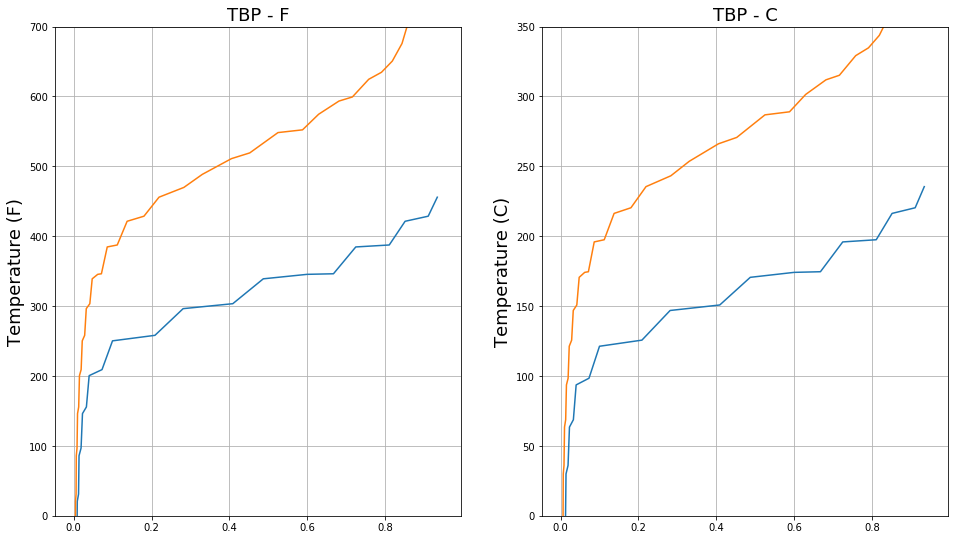

In [21]:
fig,(ax,ax2) = plt.subplots(1,2,figsize=(16,9))
for j in [7,10]:
    vol_point,BP_C_point,BP_F_point = get_TBP(model_solved,j)
    ax.plot(vol_point,BP_F_point)
    ax.set_ylim(0,700)
    ax2.plot(vol_point,BP_C_point)
    ax2.set_ylim(0,350)

ax.set_title('TBP - F',fontsize=18)
ax.set_ylabel('Temperature (F)',fontsize=18)
ax2.set_title('TBP - C',fontsize=18)
ax2.set_ylabel('Temperature (C)',fontsize=18)
ax.grid()
ax2.grid()
plt.show()